# SOMBR: Using SOM to Triage Software Bug Reports

## Setup

### Import package dependencies

In [1]:
import os
import re
import sys
import sqlite3
import pandas as pd
import numpy as np
# from tqdm import tqdm
from tqdm.notebook import trange, tqdm
import time
import datetime
 

In [2]:
from scipy import stats


In [3]:
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase, Colorbar

%matplotlib inline

sns.set(style="white")
sns.set_context("paper")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['font.family'] = ['cmr10', 'sans-serif']
# plt.rcParams['axes.formatter.use_mathtext'] = True

centim = 1/2.54  # centimeters in inches
figsize_a5 = (21*centim,14.5*centim)
figsize_a4 = (21*centim,29*centim)

figsize = (9,5)

## Account for caption space s cm
def figsize_a5_cap(cs=0): 
    return (21*centim,(14.85-cs)*centim)

def figsize_a4_cap(cs=0): 
    return (21*centim,(29.7-cs)*centim)

BASEFONTSZ = 10


In [5]:
import matplotlib.font_manager
matplotlib.font_manager._load_fontmanager(try_read_cache=False)


In [6]:
from IPython.core.display import HTML

plt.rcParams['font.family'] = ['Calibri', 'sans-serif']


# def make_html(fontname):
#     return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

# code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [7]:
RANDOM_STATE = 0
SOMGRID_M = 15
SOMGRID_N = 15
LEARNING_RATE = 0.7
N_ITERS = 150000
N_ITERS_SMALL = 10000

In [8]:
if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.join(os.path.abspath('..')))
    
    print('parent not in path, appending')
    
if os.path.abspath('.') not in sys.path:
    sys.path.append(os.path.join(os.path.abspath('.')))
    
    print('parent not in path, appending')
    
if os.path.abspath('/gcs') not in sys.path:
    sys.path.append(os.path.join(os.path.abspath('/gcs')))
    
    print('gcs not in path, appending')

parent not in path, appending
gcs not in path, appending


In [9]:
from minisom import MiniSom

In [10]:
import itertools as it


## Define Variables

In [11]:
corpora = ['cassandra',
 'groovy',
 'hadoop',
 'hbase',
 'hibernate',
 'hive',
 'infinispan',
 'jbpm',
 'lucene',
 'spark']


prepr = ['lemma', 'stopwords', 'base', 'lowercase', 'camel', 'camellower']


vectzr = ['tfidf', 'w2v', 'd2v', 'bert', 'sbert']
algorithms = ['tfidf', 'w2v', 'd2v', 'bert', 'sbert']
metrics = ['a1', 'ab', 'pr', 'qe', 'te']

metrics_labels = {
    'a1':'Accuracy@1',
    'ab':'Accuracy@BMU',
    'pr':'Precision',
    'te':'Topographic Error',
    'qe':'Quantization Error'
}


In [12]:
# base_path = "./SOM_150k"
RESULTS_BASE_SRC = "./SOMBR_Experiments/"
RESULTS_BASE_DST = "./SOMBR_Stats/"

src_csv_suffix = "150000"

In [13]:
BASE_SETUP = {
    "label": "Base",
    "base_path" : "Base",
    "epochs" : 10000,
    "random_state": 0,
    "learning_rate": 0.7,
    "initialization": 'random'

}

def new_xsetup(label=None, base_path=None, epochs=None, rs=None, lr=None, initzn=None):
    new_set = BASE_SETUP.copy()
    if label != None:
        new_set['label'] = label
    if base_path != None:
        new_set['base_path'] = base_path
    if epochs != None:
        new_set['epochs'] = epochs
    if rs != None:
        new_set['random_state'] = rs
    if lr != None:
        new_set['learning_rate'] = lr
    if initzn != None:
        new_set['initialization'] = initzn

    return new_set

In [14]:
random_seeds = [2733, 9846, 3265, 4860]
EXPERIMENTS = {
    "Base": new_xsetup(),
    "150k" : new_xsetup("SOM 150k", "150k", 150000),
    "50k" : new_xsetup("SOM 50k", "50k", 50000),
    "Random2" : new_xsetup("SOM Random 2", "Random2", rs=random_seeds[0]),
    "Random3" : new_xsetup("SOM Random 3", "Random3", rs=random_seeds[1]),
    "Random4" : new_xsetup("SOM Random 4", "Random4", rs=random_seeds[2]),
    "Random5" : new_xsetup("SOM Random 5", "Random5", rs=random_seeds[3]),
    "PCA" : new_xsetup("SOM PCA", "PCA", initzn="pca"),
    "LR1" : new_xsetup("SOM LR 1", "LR1", lr=1),
}

In [15]:
exp_csv = pd.DataFrame.from_dict(EXPERIMENTS).T
exp_csv.to_csv("./SOMBR_Stats/__ALL/SOM_Experiments.csv")
exp_csv

,label,base_path,epochs,random_state,learning_rate,initialization
Base,Base,Base,10000,0,0.7,random
150k,SOM 150k,150k,150000,0,0.7,random
50k,SOM 50k,50k,50000,0,0.7,random
Random2,SOM Random 2,Random2,10000,2733,0.7,random
Random3,SOM Random 3,Random3,10000,9846,0.7,random
Random4,SOM Random 4,Random4,10000,3265,0.7,random
Random5,SOM Random 5,Random5,10000,4860,0.7,random
PCA,SOM PCA,PCA,10000,0,0.7,pca
LR1,SOM LR 1,LR1,10000,0,1,random


## Get data from CSVs


### Aggregate results

In [16]:
def aggregate_results(exper_name, results_src=RESULTS_BASE_SRC, save=False):

    exper = EXPERIMENTS[exper_name]
    csv_suffix=str(exper['epochs'])
    
    all_results = pd.DataFrame(columns=vectzr)

    for p in prepr:
        for m in metrics:
            csv_path = os.path.join(results_src, exper['base_path'], p, "{}_{}.csv".format(m, csv_suffix))
            # print(csv_path)
            csv = pd.read_csv(csv_path)
            csv['metric'] = m
            csv['prep'] = p
            all_results = pd.concat([all_results,csv], ignore_index=True)

    all_results.rename(columns={'Unnamed: 0': 'corpus'}, inplace=True)
    
    
    if save==True:
        save_path = os.path.join(RESULTS_BASE_DST, exper['base_path'], "all_results.csv")
        all_results.to_csv(save_path, index=False)

    return all_results


def load_aggregate_results(exper_name):
    exper = EXPERIMENTS[exper_name]
        
    load_path = exper['base_path']
    load_path = os.path.join(RESULTS_BASE_DST, exper['base_path'])
    load_csv  = os.path.join(RESULTS_BASE_DST, exper['base_path'], "all_results.csv")
        
    if os.path.isfile(load_csv):
        return pd.read_csv(load_csv)
    else: 
        if not os.path.exists(load_path):
            os.makedirs(load_path)
        return aggregate_results(exper_name, save=True)



In [17]:
all_experiment_results = {}
for k in EXPERIMENTS.keys():
    all_experiment_results[k] = load_aggregate_results(k)
    

all_results_df_test = load_aggregate_results("Base")

for e in EXPERIMENTS.keys():
    _ = aggregate_results(e, save=True)



In [18]:
vecmap = {
    'tfidf': "TF-IDF", 
    'w2v': "Word2Vec", 
    'd2v': "Doc2Vec",
    'bert': "BERT", 
    'sbert': "SBERT"
}

In [19]:
EXPERIMENTS['Base']

{'label': 'Base',
 'base_path': 'Base',
 'epochs': 10000,
 'random_state': 0,
 'learning_rate': 0.7,
 'initialization': 'random'}

## Process results

In [20]:
m_ranks_df = {}

### Get Ranks

In [21]:
def generate_ranks(exper_name, save=False):
    exper = EXPERIMENTS[exper_name]
    
    all_results_df = load_aggregate_results(exper_name)

    all_ranks_df = pd.DataFrame(columns=vectzr)
    
    for m in metrics:

        df_ = all_results_df[all_results_df['metric']==m]
        perfs = df_[algorithms].values
        meta_ = df_[['corpus', 'metric', 'prep']]

        if (m == "qe") | (m == "te"): ## Lower is better
            ranks = np.array([stats.rankdata(p) for p in perfs])
        else:
            ranks = np.array([stats.rankdata(-p) for p in perfs]) ## Higher is better



        ranks_df = pd.DataFrame(ranks,columns=algorithms, index=df_.index)
        ranks_meta = pd.concat([ranks_df, meta_], axis=1)

        all_ranks_df = pd.concat([all_ranks_df, ranks_meta], axis=0)
        
    save_path  = os.path.join(RESULTS_BASE_DST, exper['base_path'], "all_ranks.csv")
    if save==True:
        all_ranks_df.to_csv(save_path, index=False)

    return all_ranks_df


def load_all_ranks(exper_name):
    load_path  = os.path.join(RESULTS_BASE_DST, EXPERIMENTS[exper_name]['base_path'], 
                              "all_ranks.csv")
    
    if os.path.isfile(load_path):
        return pd.read_csv(load_path)
    else:
        return generate_ranks(exper_name, save=True)

    



all_ranks_df = load_all_ranks("Base")

for e in EXPERIMENTS.keys():
    _ = generate_ranks(e, save=True)

    

### Get results per metric

In [22]:

def results_permetric(exper_name, save=False):
    m_results = {}
    m_ranks = {}
    
    mean_scores_df = pd.DataFrame(index=vectzr)
    mean_ranks_df = pd.DataFrame(index=vectzr)

    
    mean_path   = os.path.join(RESULTS_BASE_DST, EXPERIMENTS[exper_name]['base_path'], 
                          "mean_scores.csv")
    
    mean_ranks_path   = os.path.join(RESULTS_BASE_DST, EXPERIMENTS[exper_name]['base_path'], 
                          "mean_ranks.csv")

    
    all_results = load_aggregate_results(exper_name)
    all_ranks   = load_all_ranks(exper_name)

    for m in metrics:
        save_path        = os.path.join(RESULTS_BASE_DST, EXPERIMENTS[exper_name]['base_path'], 
                      "scores_{}.csv".format(m))
        
        save_ranks_path  = os.path.join(RESULTS_BASE_DST, EXPERIMENTS[exper_name]['base_path'], 
                      "ranks_{}.csv".format(m))
        
        if (not save) and (os.path.isfile(save_path)) and (os.path.isfile(save_ranks_path)):
            m_results[m] = pd.read_csv(save_path)
        else:
            met_results = all_results.loc[all_results['metric']==m,:].copy()
            met_results.to_csv(save_path, index=False)
            m_results[m] = met_results
            
            met_ranks = all_ranks.loc[all_ranks['metric']==m,:].copy()
            met_ranks.to_csv(save_ranks_path, index=False)
            m_ranks[m] = met_ranks
            
            

    if (not save) and (os.path.isfile(mean_path)) and (os.path.isfile(mean_ranks_path)):
        mean_scores_df = pd.read_csv(mean_path)
        mean_ranks_df = pd.read_csv(mean_ranks_path)
    else:

        for m in metrics:
            mean_scores_df[metrics_labels[m]] = m_results[m].loc[:,vectzr].mean()
            mean_ranks_df[metrics_labels[m]] = m_ranks[m].loc[:,vectzr].mean()

        mean_scores_df.T.to_csv(mean_path)
        mean_ranks_df.T.to_csv(mean_ranks_path)
    
    return m_results, mean_scores_df, mean_ranks_df

m_results, mean_scores_df, mean_ranks_df = results_permetric("Base")

for e in EXPERIMENTS.keys():
    _,_,_ = results_permetric(e, save=True)


### Get statistics

In [23]:

friedman_df = pd.DataFrame([])
fi = 0
friedman_res = {}

for e in EXPERIMENTS.keys():
    
    df_e = load_all_ranks(e)
    friedman_res[e] = {}

    for mi in metrics:

        df_ = df_e[df_e['metric']==mi]
        
        
        
        friedman_res[e][fi] = {}

        friedman_res[e][fi]['SOM Setup'] = e
        friedman_res[e][fi]['metric'] = mi

        vals = [df_[a] for a in algorithms]
        fresult = stats.friedmanchisquare(*vals)
        friedman_res[e][fi]['Test Statistic'] = fresult[0]
        friedman_res[e][fi]['p-value'] = fresult[1]
        friedman_res[e][fi]['Significant'] =  fresult[1] < 0.001
        

        fi += 1
        
    friedman_df = pd.concat([friedman_df,pd.DataFrame.from_dict(friedman_res[e]).T], axis=0)
        

friedman_df['p-value'] = friedman_df['p-value'].astype(float)
# friedman_df.to_csv("{}__ALL/friedman_tests.csv".format(RESULTS_BASE_DST), float_format="%.50f")


## Done

## Make sure the R notebook has been run

In [24]:
# mh = pd.read_csv('./results_summary/a1h.csv').replace("NA", np.nan)


In [25]:
def make_ph_df(em_df):
    
    len_a = len(vectzr)

    nans_mat = np.empty((len_a,len_a))
    nans_mat[:] = np.nan

    r_nem_df = pd.DataFrame(nans_mat,
                 columns=vectzr,
                 index=vectzr,
                )

    for i in range(len_a-1):
        for j in range(len_a-1):
            r_nem_df.iloc[i+1, j] = em_df.iloc[i, j]
            
    return r_nem_df
    

In [26]:
vectzr

['tfidf', 'w2v', 'd2v', 'bert', 'sbert']

In [27]:
blues = mpl.colormaps['Blues'].resampled(5)
whites = ["#EEE"]*5

cmap = [blues(i) for i in range(5)]


In [28]:
# r_nem_df

In [29]:
EXP_randoms = ['Base', 'Random2', 'Random3', 'Random4', 'Random5']
EXP_map = ['Base', '150k', '50k','PCA', 'LR1']

In [30]:
figsize_a4

(8.26771653543307, 11.417322834645669)

In [31]:

def plot_all_pairwise_pvals(EXP_list, metrics_list, save_path, show=False, save=False):
    
    fig = plt.figure(figsize=(14,8), layout='constrained')
    subfigs = fig.subfigures(len(EXP_list), 
                             len(metrics), 
                             wspace=0.02)

    for ei, e in enumerate(EXP_list):
        for mi, m in enumerate(metrics_list):
            em_df = pd.read_csv("{}__ALL/R_posthoc_{}_{}.csv".format(RESULTS_BASE_DST, e, m))

            em_df.set_index(pd.Index(vectzr[1:]), inplace=True)

            r_nem_df = make_ph_df(em_df)


            nf = r_nem_df.copy()
            all_results_df = load_aggregate_results(e)
            all_ranks_df = load_all_ranks(e)
            title='title'
            df = nf.copy()

            x = nf.copy()
            x = np.round(x,3)



            df[(x <  0.001 ) & (x >= 0     )] =  3  # v highly sig
            df[(x <  0.01  ) & (x >= 0.001 )] =  2  # highly sig
            df[(x <  0.05  ) & (x >= 0.01  )] =  1  # sig
            df[(x >= 0.05  )                ] =  0  # ns
            df[(x.isna())                   ] = -1  # nan


            count=1

            sf = subfigs[ei][mi]


            ##############################
            ## Make triangle + avg rank subplots
            ##############################
            spax = sf.subplots(1,2, 
                              width_ratios=(1,12),
                              )



            ax = spax[1]

            hax = sns.heatmap(
                df, vmin=-1, vmax=3, 
                cmap=ListedColormap(cmap), center=1,
                # square=True,
                annot=True,
                cbar=False, ax=ax,
                annot_kws={'size': 7}

            )


            ax.yaxis.set_tick_params(labelrotation=0)

            cbar_ax = hax.figure.add_axes([0.77, 0.55, 0.04, 0.3])
            cbar = ColorbarBase(cbar_ax, cmap=blues,
                                norm=mcolors.NoNorm(),
                                boundaries=[0, 1, 2, 3, 4])
            cbar.set_ticks(list(np.linspace(0, 4, 5)), 
                           labels=['', 'NS', '*', '**', '***'],
                          )

            cbar.outline.set_linewidth(0)
            cbar.outline.set_edgecolor('0')
            cbar.ax.tick_params(size=0)


            for t in hax.texts:
                h0 = int(t.get_position()[0])
                h1 = int(t.get_position()[1])
                current_text = t.get_text()

                new_t = nf.iloc[h1,h0]
                if np.isnan(new_t):
                    new_t = ""
                else:
                    new_t = "<.001" if np.round(new_t,3) < 0.001 else np.round(new_t,3)

                t.set_text(new_t)


                ##############################
                ## Make avg rank subplot
                ##############################

            ardf_ = all_ranks_df[all_ranks_df['metric']==m]
            ardf_mean = ardf_.loc[:,vectzr+['metric']].groupby('metric').mean().T

            axr=spax[0]
            sns.heatmap(ardf_mean, 
                        cmap='Greys',
                        cbar=False, ax=axr,
                        annot=True,
                        annot_kws={'size': 8},
                        vmin=1, vmax=6, 
                       )
            axr.yaxis.set_tick_params(labelrotation=0)
            axr.xaxis.set_ticks([])
            axr.yaxis.set_ticks([])

            axr.set_xlabel('Avg\nRanks', fontsize=7)

            if ei == 0:
                sf.suptitle("{}".format(metrics_labels[m]))

            if mi == 0 :
                sf.supylabel("{}".format(e))
    
    if save==True:
        fig.savefig(save_path, bbox_inches='tight')

    if show==False:
        print("Done, show=",show)
        plt.close(fig)
    else:
        plt.show()

    


In [32]:
plot_all_pairwise_pvals(EXP_randoms, metrics, save_path="./SOMBR_Stats/__IMG/PairwisePVals_Randoms.png", save=True)


Done, show= False


In [33]:
plot_all_pairwise_pvals(EXP_map, metrics, save_path="./SOMBR_Stats/__IMG/PairwisePVals_MapInit.png", save=True)


Done, show= False


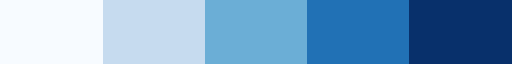

In [34]:
blues = mpl.colormaps['Blues'].resampled(5)
blues

In [35]:
pairs = {}
pairs_vals = {}
pairs_df = pd.DataFrame(columns=list(EXPERIMENTS.keys()))
EXP_list = EXP_randoms + EXP_map[1:]


In [36]:

fig, axes = plt.subplots(2,3, figsize=(9,8), sharey=True, layout='constrained')

ax = axes.flatten()

for mi, m in enumerate(metrics):
    pairs[m] = {}
    pairs_exp_df = pd.DataFrame(index=[])

    pairs_vals[m] = {}
    pairs_vals_df = pd.DataFrame(index=[])
    for ei, e in enumerate(EXP_list):
        pairs[m][e] = {}
        pairs_vals[m][e] = {}
        em_df = pd.read_csv("{}__ALL/R_posthoc_{}_{}.csv".format(RESULTS_BASE_DST, e, m))

        em_df.set_index(pd.Index(vectzr[1:]), inplace=True)

        r_nem_df = make_ph_df(em_df)


        nf = r_nem_df.copy()
        all_results_df = load_aggregate_results(e)
        all_ranks_df = load_all_ranks(e)
        title='title'
        df = nf.copy()

        x = nf.copy()
        x = np.round(x,3)



        df[(x <  0.001 ) & (x >= 0     )] =  3  # v highly sig
        df[(x <  0.01  ) & (x >= 0.001 )] =  2  # highly sig
        df[(x <  0.05  ) & (x >= 0.01  )] =  1  # sig
        df[(x >= 0.05  )                ] =  0  # ns
        df[(x.isna())                   ] = -1  # nan
        
        combs = it.combinations(df.columns,2)

        for i, j in combs:
            pairs[m][e]["{} - {}".format(vecmap[i],vecmap[j])] = df.loc[j,i]
            pairs_vals[m][e]["{} - {}".format(vecmap[i],vecmap[j])] = x.loc[j,i]
            
        pairs_exp_df = pd.concat([pairs_exp_df,pd.DataFrame([pairs[m][e]], index=[e])])
        pairs_vals_df = pd.concat([pairs_vals_df,pd.DataFrame([pairs_vals[m][e]], index=[e])])
    
    pairs_exp_df_T = pairs_exp_df.T.copy()
    pairs_vals_df_T = pairs_vals_df.T.copy()


    hax = sns.heatmap(
                pairs_exp_df_T, 
                vmin=0, vmax=3, 
                cmap=ListedColormap(cmap), center=1,
                square=True,
                # annot=True,
                cbar=False, 
                ax=ax[mi],
                linewidths=.1,
                linecolor="w",
            )

    
    ax[mi].set_title(metrics_labels[m], fontsize=BASEFONTSZ*1.4)

    
ax[-1].remove()
cbar_ax = ax[-2].figure.add_axes([.75, 0.08, 0.02, 0.35])

cbar = ColorbarBase(cbar_ax, 
                    cmap=blues,
                    norm=mcolors.NoNorm(),
                    alpha=.6,
                    boundaries=[0, 1, 2, 3,4],
                   )

cbar.set_ticks([0,1,2,3,4], 
               labels=['', 'NS', '*', '**', '***'],
              )
cbar.outline.set_linewidth(0)
cbar.outline.set_edgecolor('0')
cbar.ax.tick_params(size=0)

fig.savefig("./SOMBR_Stats/__IMG/Pairwise_pvals_diffs_square.png", bbox_inches="tight")
plt.close(fig)


### Rank Heatmaps

In [37]:

def plot_ranks_heatmap(arb_df, metrics_list, save=False, show=False):
    
    fig, axes = plt.subplots(1, len(metrics_list), figsize=(3*len(metrics_list), 2), 
                           sharey=True,
                          )
    fig.subplots_adjust(wspace=.2)

    for mi, m in enumerate(metrics_list):
        axi = axes[mi]
        ranks_ = arb_df[arb_df['metric']==m].copy()

        rank_frq = pd.concat([
                ranks_.iloc[:,:5].apply(pd.value_counts),
                pd.DataFrame(index=np.arange(.5,6,.5))
                ], 
                axis=1,
                ignore_index=False).sort_index().T.iloc[:,1:-1]

        im = axi.imshow(rank_frq,
                        cmap=sns.color_palette("ch:start=2.9,rot=-.05,gamma=.6,hue=1,light=.8,dark=.1", 
                                               as_cmap=True),
                        aspect=1.3)

        xlabs = rank_frq.columns
        ylabs = rank_frq.index

        xlabskeep = [ int(i) if i==int(i) else None for i in xlabs ]

        axi.set_title(metrics_labels[m], fontsize=BASEFONTSZ*1.2)

        axi.set_yticks(np.arange(len(ylabs)), labels=ylabs)
        axi.set_xticks(range(0,len(xlabs)))
        axi.set_xticklabels(xlabskeep)
        axi.tick_params(axis='y', labelsize=BASEFONTSZ)
        axi.tick_params(axis='x', labelsize=BASEFONTSZ)
        axi.margins(0)
        for si in axi.spines:
            axi.spines[si].set_linewidth(0)
        axi.set_facecolor('#F5F5F5')

    
    if save==True:
        fig.savefig("./SOMBR_Stats/__IMG/RankHeatmaps-{}.png".format("-".join(metrics_list)), bbox_inches='tight')
        
    if show==False:
        print("Done, show=",show)
        plt.close(fig)
    else:
        plt.show()

    return


all_ranks_base_df = load_all_ranks("Base")
plot_ranks_heatmap(all_ranks_base_df, ['a1', 'ab', 'pr'], save=True)
plot_ranks_heatmap(all_ranks_base_df, ['te', 'qe'], save=True)

Done, show= False
Done, show= False


In [38]:
vecmap

{'tfidf': 'TF-IDF',
 'w2v': 'Word2Vec',
 'd2v': 'Doc2Vec',
 'bert': 'BERT',
 'sbert': 'SBERT'}

In [39]:
vectzr

['tfidf', 'w2v', 'd2v', 'bert', 'sbert']

### SOM Map Params 

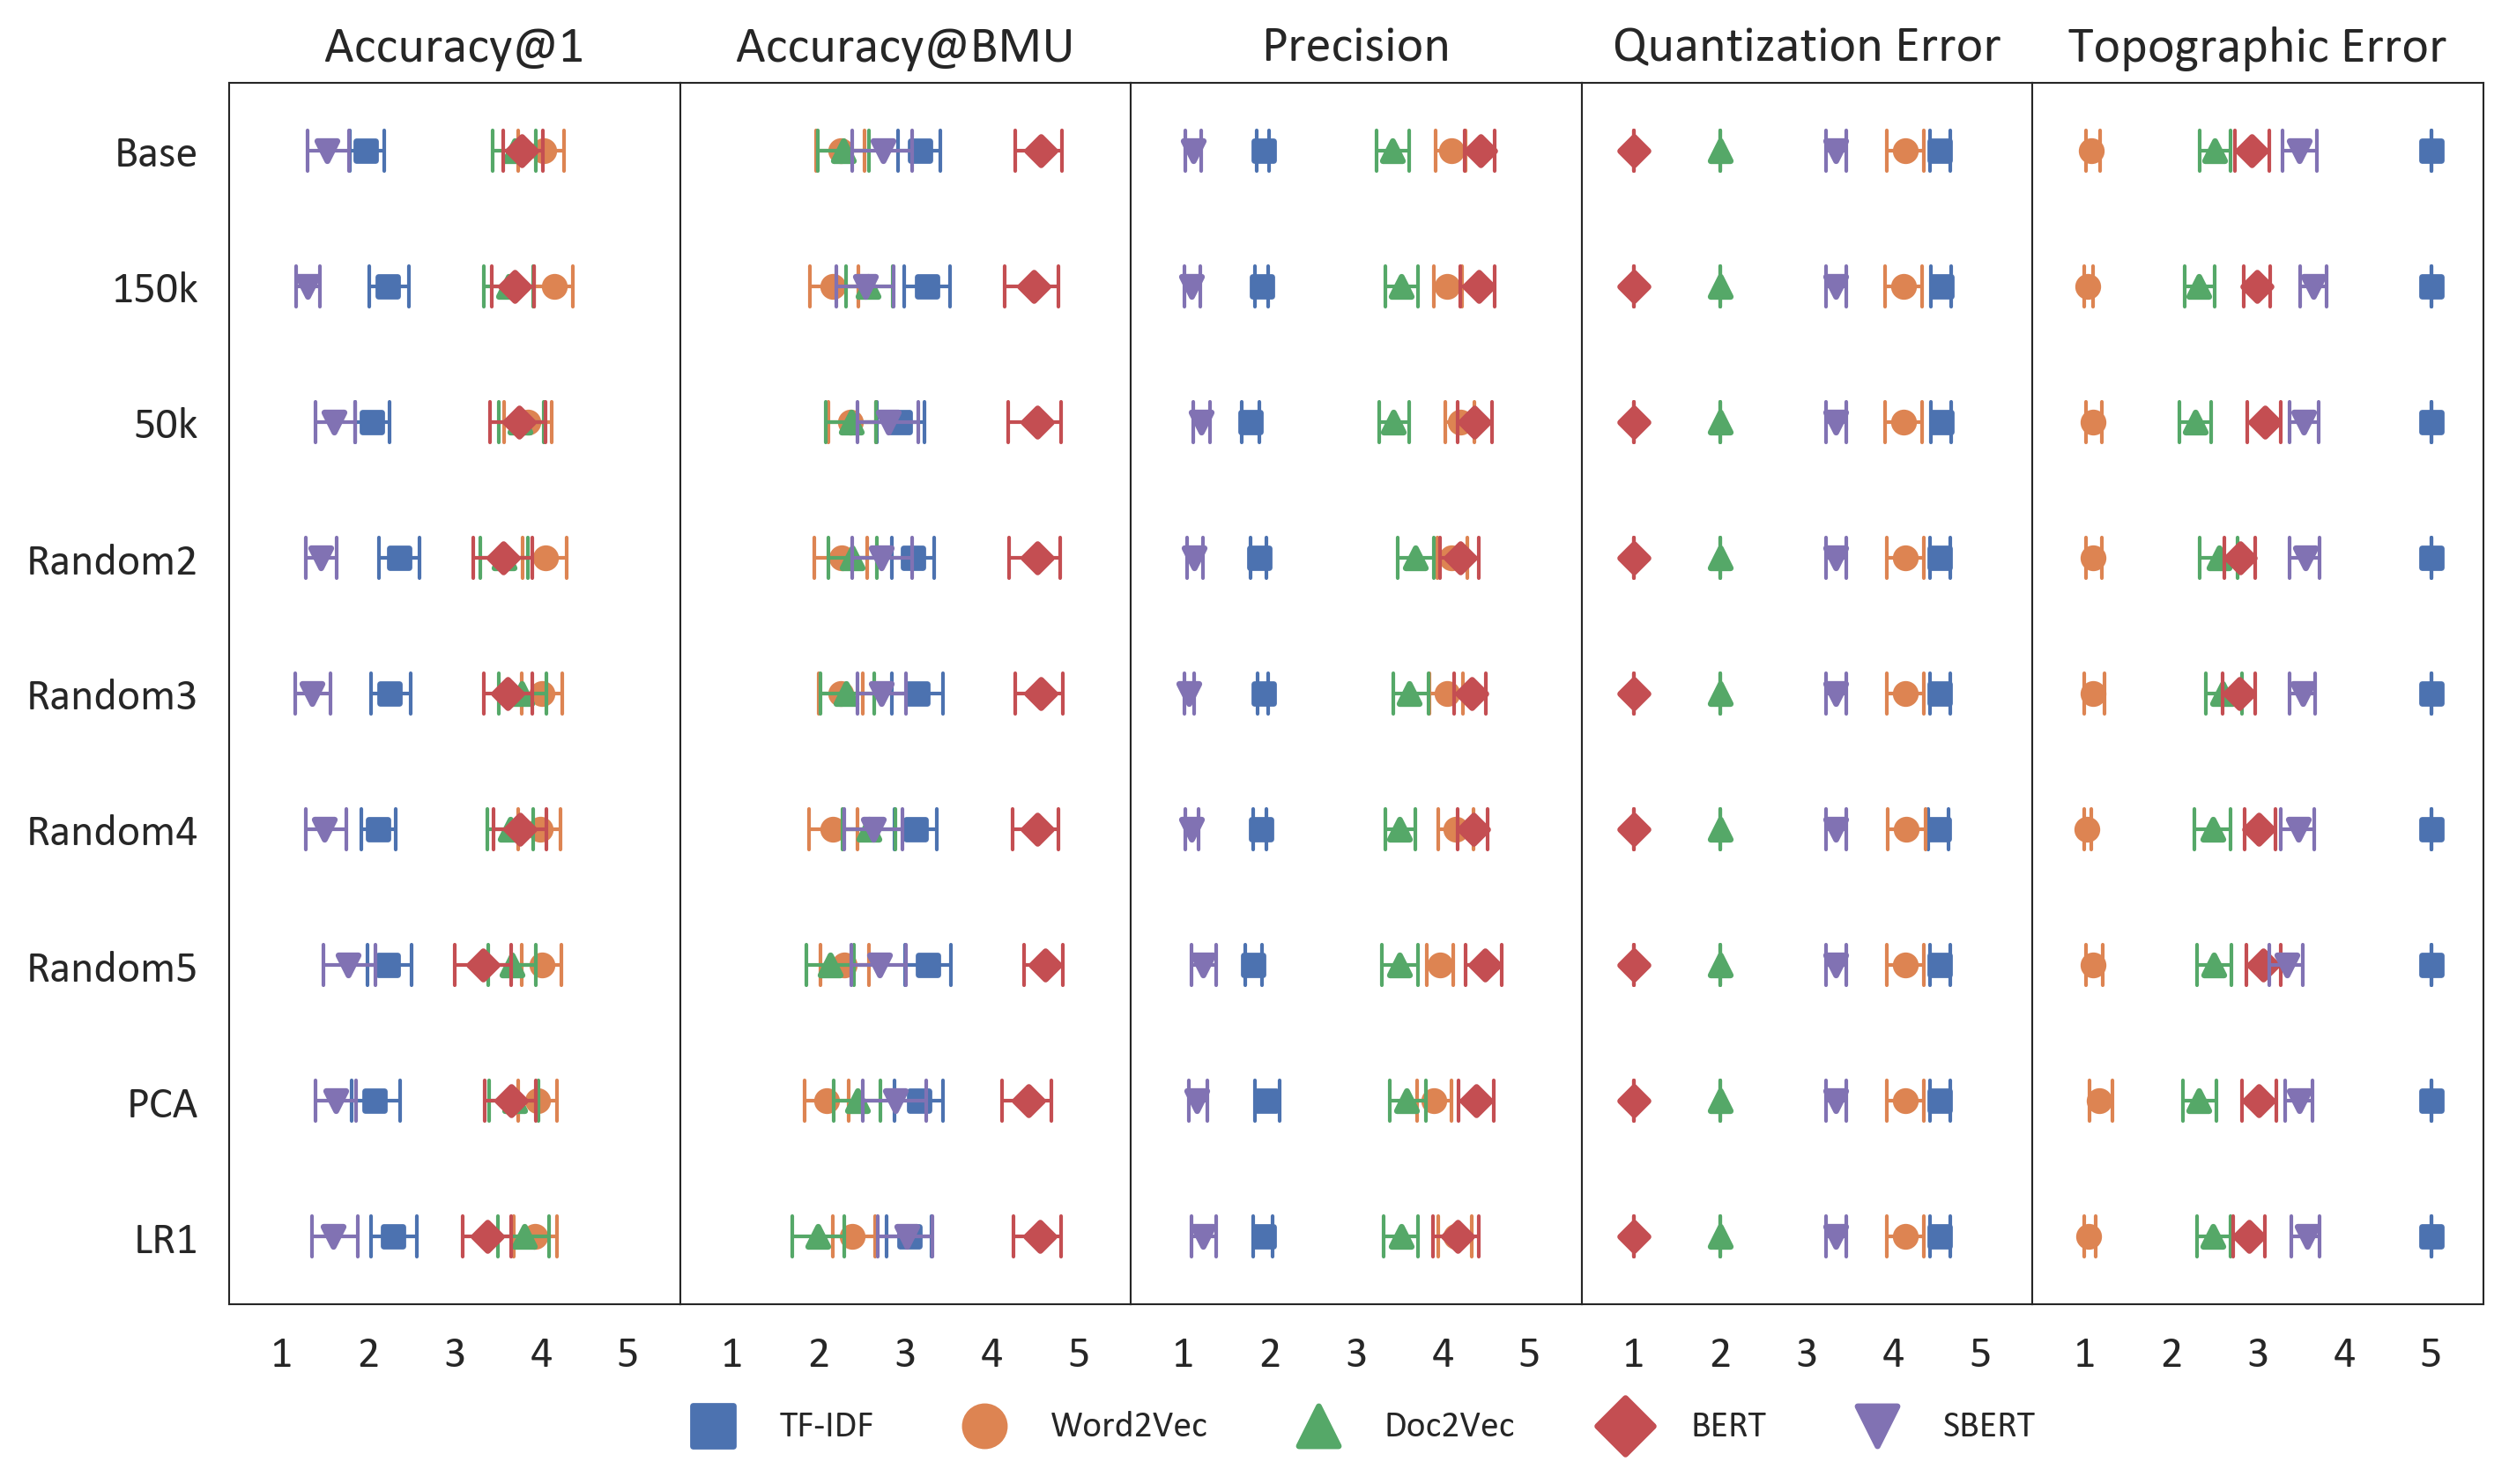

In [40]:
fig, ax = plt.subplots(1, 5, #1, 
                       figsize=(11,6), 
                       sharex=True, 
                       sharey=True,
                       # layout='constrained'
                       gridspec_kw={'wspace':0}
                      )

for mi, m in enumerate(metrics):
    boxen_df = pd.DataFrame(columns=["variable","value","experiment"])
    for ei, e in enumerate(list(EXPERIMENTS.keys())):

        me_path = "{}{}/ranks_{}.csv".format(RESULTS_BASE_DST, e, m)
        # me_path = "{}{}/scores_{}.csv".format(RESULTS_BASE_DST, e, m)
        me_df = pd.read_csv(me_path)
        me_df.index = me_df.apply(lambda x: "{}-{}".format(x['corpus'],x['prep']) , axis=1)
        melted_me_df = me_df.iloc[:,:5].melt()
        melted_me_df['experiment'] = e
        boxen_df_ = pd.concat([boxen_df,melted_me_df], ignore_index=True)
        
        boxen_df = boxen_df_.copy()
        boxen_df = boxen_df.replace(vecmap)
        
    
    sns.pointplot(data=boxen_df, 
                  y='experiment', 
                  hue='variable', 
                  x='value', 
                  join=False,
                  errorbar="ci",
                  # errorbar=("pi",90),
                  scale=1,
                  # dodge=True,
                  seed=0,
                  errwidth=1,
                  capsize=.3,
                  ax=ax[mi],
                  markers=['s','o','^','D','v']
                  
    )
    
    ax[mi].set_xlabel(None)
    ax[mi].set_ylabel(None)
    ax[mi].set_title(metrics_labels[m], fontsize=BASEFONTSZ*1.4)
    ax[mi].set_xticks([1,2,3,4,5])
    # ax[mi].set_yticklabels(fontsize=BASEFONTSZ)
    ax[mi].tick_params(labelsize=BASEFONTSZ*1.2)
    ax[mi].margins(x=.15)
    # if mi == 4:
    #     ax[mi].legend(frameon=False,
    #                   loc='center', 
    #                   bbox_to_anchor=(1.3, .5),
    #                   ncol=1
    #                  )
    if mi == 2:
        ax[mi].legend(frameon=False,
                      loc='center', 
                      bbox_to_anchor=(0.5, -.1),
                      fontsize=BASEFONTSZ,
                      markerscale=2,
                      ncol=5
                     )
        
    
    else:
        ax[mi].legend([], frameon=False)
    
    # if mi == 4:
    #     ax[mi].set_xticklabels([])
        
    for si in ax[mi].spines:
        ax[mi].spines[si].set_linewidth(.5)
        

    

fig.savefig("./SOMBR_Stats/__IMG/Ranks_All_SOM_Experiments.png", bbox_inches='tight')
plt.show()

## Make csv of all results to compare som params


### Violin plots


In [41]:
w_cmap = sns.color_palette(["w"]*5, as_cmap=True)


In [42]:
all_results_base_df = load_aggregate_results("Base")

In [43]:
def plot_violins_permetric(results_df, save=False, show=False):
    ax1_legend = None
    
    for mi in metrics:
        fig, ax = plt.subplots(2, 3, figsize=figsize, 
                              sharex=True,
                              sharey=True,
                              layout='tight')
        

        for vi in range(1,len(vectzr)+1):

            axi = ax.flatten()[vi]

            s_ = results_df[results_df['metric']==mi].copy()
            labels = s_['label'] = s_['corpus'] + '-' + s_['prep']
            labels = labels.to_list() * 5
            s_.set_index('label', inplace=True)
            s_melt = s_.iloc[:,:5].melt()
            s_melt['corpus'] = [i.split('-')[0] for i in labels]
            s_melt['prep'] = [i.split('-')[1] for i in labels]

            s_melt_v = s_melt[s_melt['variable']==vectzr[vi-1]]


            sns.stripplot(data=s_melt_v, 
                          x='prep', 
                          y='value', 
                          hue='corpus', 
                          ax=axi, s=6, 
                          jitter=.25,
                         )
            sns.violinplot(data=s_melt_v, y='value', x='prep', 
                           c=w_cmap, 
                           ax=axi,
                           linewidth=.5,
                           color='white', 
                           alpha=.5,
                           # cut=0,
                           inner=None)
            if vi==1:
                ax1_legend = ax[0][1].get_legend_handles_labels()
            

            axi.legend([], frameon=False)
            axi.set_ylabel(None)
            axi.set_title(vi, y=-.2, fontsize=BASEFONTSZ*1.2)
            for si in axi.spines:
                axi.spines[si].set_linewidth(.5)

            axi.set_title(vecmap[vectzr[vi-1]], y=1, fontsize=BASEFONTSZ*1.2)

        for i in range(3):
            ax0 = ax[1][i]
            ax0.set_ylabel(None)

            ax0.tick_params(axis='x', rotation = 90, labelsize=BASEFONTSZ)#, pad=30)
            ax0.tick_params(top=False, labeltop=False, bottom=False, labelbottom=True)


        axz = ax[0][0]
        axz.tick_params(top=False, labeltop=False, bottom=False, labelbottom=False)
        axz.set_title(metrics_labels[mi], y=.77, fontsize=BASEFONTSZ*1.6)
        axz.legend(*ax1_legend)
        axlegend = axz.legend(*ax1_legend,
                              loc='center', 
                              bbox_to_anchor=(0.05, -0.1, .9,1),
                              ncol=2,
                              borderpad=.5,
                              mode='expand',
                              labelspacing=.75,
                              fontsize=10,
                              markerscale=1.5,
                              frameon=False,
                              handletextpad=.25,
                              )
        
        

        for si in axz.spines:
            axz.spines[si].set_linewidth(0)
            
        if save==True:
            fig.savefig("./SOMBR_Stats/__IMG/ViolinStripPlotValues-{}.png".format(mi))

        if show==False:
            print("Done, show=",show)
            plt.close(fig)
        else:
            plt.show()
        
plot_violins_permetric(all_results_base_df, save=True)

Done, show= False
Done, show= False
Done, show= False
Done, show= False
Done, show= False


In [44]:
all_results_base_df = load_aggregate_results("Base")

In [45]:
all_results_base_df.head()

,tfidf,w2v,d2v,bert,sbert,corpus,metric,prep
0,0.094488,0.062992,0.070866,0.062992,0.082240,cassandra,a1,lemma
1,0.393728,0.306620,0.324042,0.305459,0.373984,groovy,a1,lemma
2,0.022540,0.018692,0.023090,0.019791,0.031336,hadoop,a1,lemma
3,0.079933,0.085762,0.079101,0.076603,0.079101,hbase,a1,lemma
4,0.275362,0.244306,0.285714,0.296066,0.256729,hibernate,a1,lemma


In [46]:
parcols = ['base', 'lowercase', 'camel', 'camellower', 'stopwords', 'lemma']

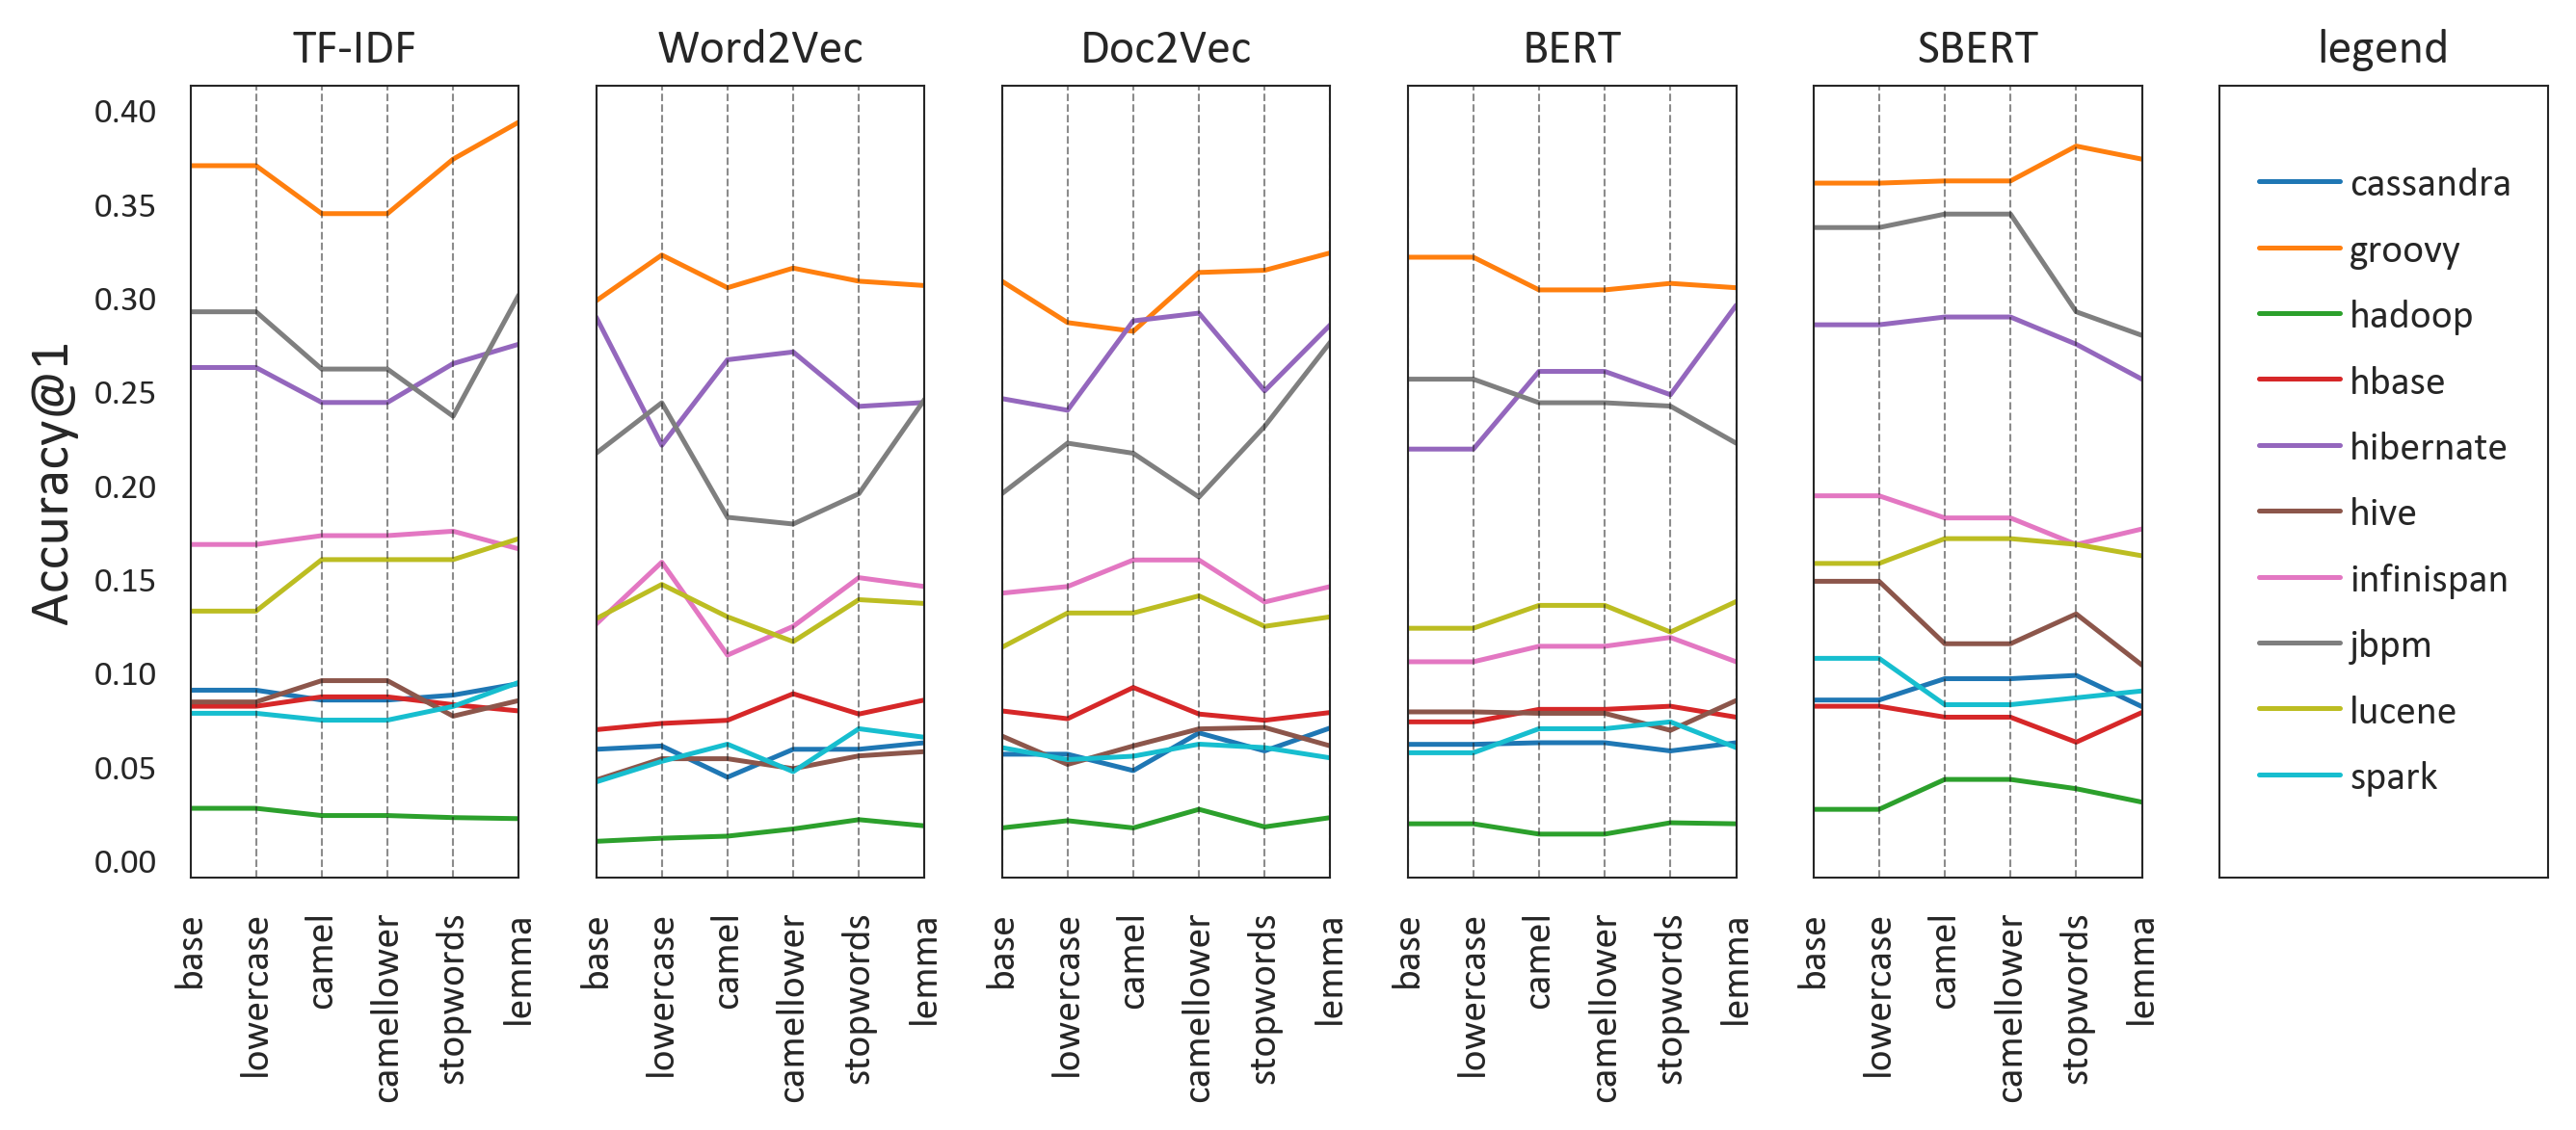

In [47]:
fig, ax = plt.subplots(1,6, figsize=(9,4), 
                       sharey=True, 
                      layout='tight')

pleg = None
for vi, v in enumerate(vectzr):

    base_ = all_results_base_df.loc[all_results_base_df['metric']=='a1',:].iloc[:,[vi,5,7]].copy()
    base_ = base_.pivot(index='corpus', columns='prep')[v].reset_index()

    pd.plotting.parallel_coordinates(base_, 'corpus', 
                                     cols=parcols,
                                     colormap="tab10", 
                                     ax=ax[vi],
                                     axvlines = True,
                                     axvlines_kwds={'linewidth':.5, 
                                                    'color':'k', 
                                                    'alpha':.5,
                                                    'linestyle':'--'
                                                   }
                                    )
    
    ax[vi].set_title(vecmap[v], fontsize=BASEFONTSZ*1.2)
    ax[vi].xaxis.set_tick_params(labelrotation=90, labelsize=BASEFONTSZ)
    ax[vi].grid(axis='y', visible=False)
    ax[vi].grid(axis='x', visible=False)

    if vi == 0:
        pleg = ax[vi].get_legend_handles_labels()
    ax[vi].legend([], frameon=False)
        


ax[-1].legend(*pleg, 
             loc='center', 
              bbox_to_anchor=(0, 0, .9,1),
              ncol=1,
              borderpad=.5,
              mode='expand',
              labelspacing=.75,
              fontsize=10,
              markerscale=1.5,
              frameon=False,
              handletextpad=.25,)

ax[-1].set_xticks([])
ax[-1].set_title('legend', fontsize=BASEFONTSZ*1.2)
ax[0].set_ylabel("Accuracy@1", fontsize=BASEFONTSZ*1.4)

for axi in ax:
    for si in axi.spines:
        axi.spines[si].set_linewidth(.5)
        

In [48]:
metrics

['a1', 'ab', 'pr', 'qe', 'te']

In [49]:
def plot_parallels(metric_list, save=False,show=False):

    fig, ax = plt.subplots(len(metric_list),5, 
                           figsize=(9,2.5*len(metric_list)), 
                           sharey='row', 
                           sharex='col',
                          layout='tight'
                          )
    pleg = None

    for mi, m in enumerate(metric_list):

        for vi, v in enumerate(vectzr):

            base_ = all_results_base_df.loc[all_results_base_df['metric']==m,:].iloc[:,[vi,5,7]].copy()
            base_ = base_.pivot(index='corpus', columns='prep')[v].reset_index()

            pd.plotting.parallel_coordinates(base_, 'corpus', 
                                             cols=parcols,
                                             colormap="tab10", 
                                             ax=ax[mi][vi],
                                             axvlines = True,
                                             axvlines_kwds={'linewidth':.5, 
                                                            'color':'k', 
                                                            'alpha':.5,
                                                            'linestyle':'--'
                                                           }
                                            )
            if mi == 0:
                ax[mi][vi].set_title(vecmap[v], fontsize=BASEFONTSZ*1.2)
            ax[mi][vi].xaxis.set_tick_params(labelrotation=90, labelsize=BASEFONTSZ)
            ax[mi][vi].grid(axis='y', visible=False)
            ax[mi][vi].grid(axis='x', visible=False)

            if (vi == 0) & (mi == 0):
                pleg = ax[mi][vi].get_legend_handles_labels()
            ax[mi][vi].legend([], frameon=False)

            for si in ax[mi][vi].spines:    
                ax[mi][vi].spines[si].set_linewidth(.5)


        ax[mi][0].set_ylabel(metrics_labels[m], fontsize=BASEFONTSZ*1.4)


    fleg = ax[-1][2].legend(*pleg, 
        loc='center', 
        ncol=10,
        borderpad=.5,
        mode='expand',
        labelspacing=.85,
        fontsize=BASEFONTSZ*.8,
        frameon=False,
        handletextpad=.75,
        handlelength=1,
        bbox_transform=fig.transFigure,
        bbox_to_anchor=(0.055, 0.01, .94, 0)
    )
    for line in fleg.get_lines():
        line.set_linewidth(2)
    if save ==True:
        fig.savefig('./SOMBR_Stats/__IMG/ParallelPlots_{}'.format("-".join(metric_list)), 
                   bbox_inches='tight')
    if show ==True:

        plt.show()
    else:
        plt.close()

In [50]:
plot_parallels(['a1','ab','pr'], save=True,show=False)

In [51]:
plot_parallels(['qe','te'], save=True,show=False)

## Ranks Histograms

In [52]:
all_ranks_base_df = load_all_ranks("Base")
all_ranks_base_df

,tfidf,w2v,d2v,bert,sbert,corpus,metric,prep
0,1.0,4.5,3.0,4.5,2.0,cassandra,a1,lemma
1,1.0,4.0,3.0,5.0,2.0,groovy,a1,lemma
2,3.0,5.0,2.0,4.0,1.0,hadoop,a1,lemma
3,2.0,1.0,3.5,5.0,3.5,hbase,a1,lemma
4,3.0,5.0,2.0,1.0,4.0,hibernate,a1,lemma
...,...,...,...,...,...,...,...,...
295,5.0,1.0,3.0,4.0,2.0,hive,te,camellower
296,5.0,1.0,2.0,3.0,4.0,infinispan,te,camellower
297,5.0,1.0,3.0,2.0,4.0,jbpm,te,camellower
298,5.0,1.0,4.0,2.0,3.0,lucene,te,camellower


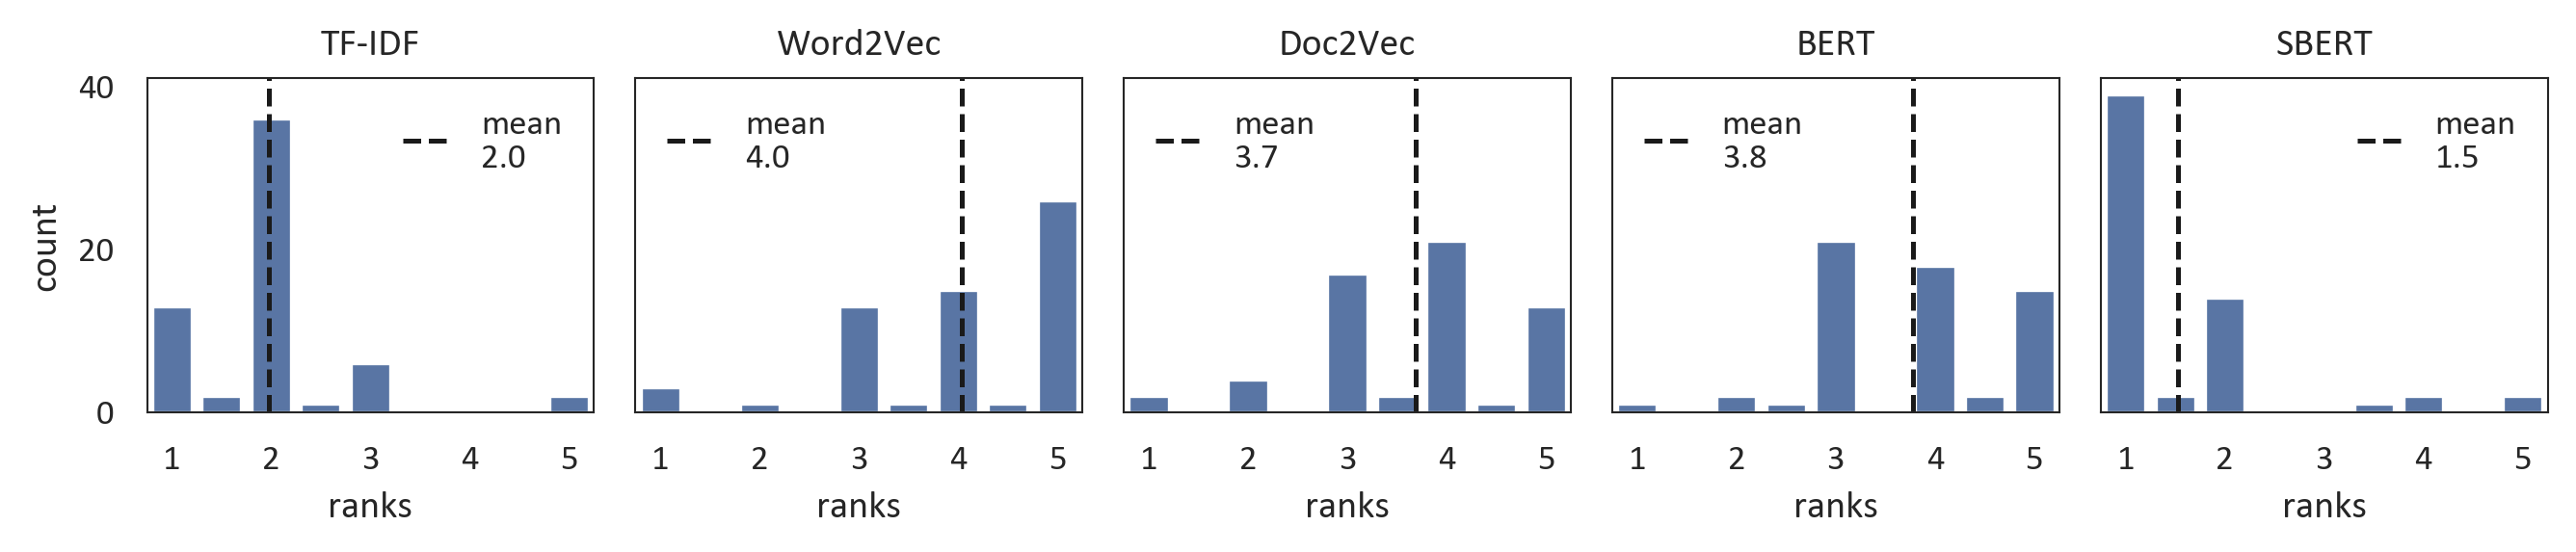

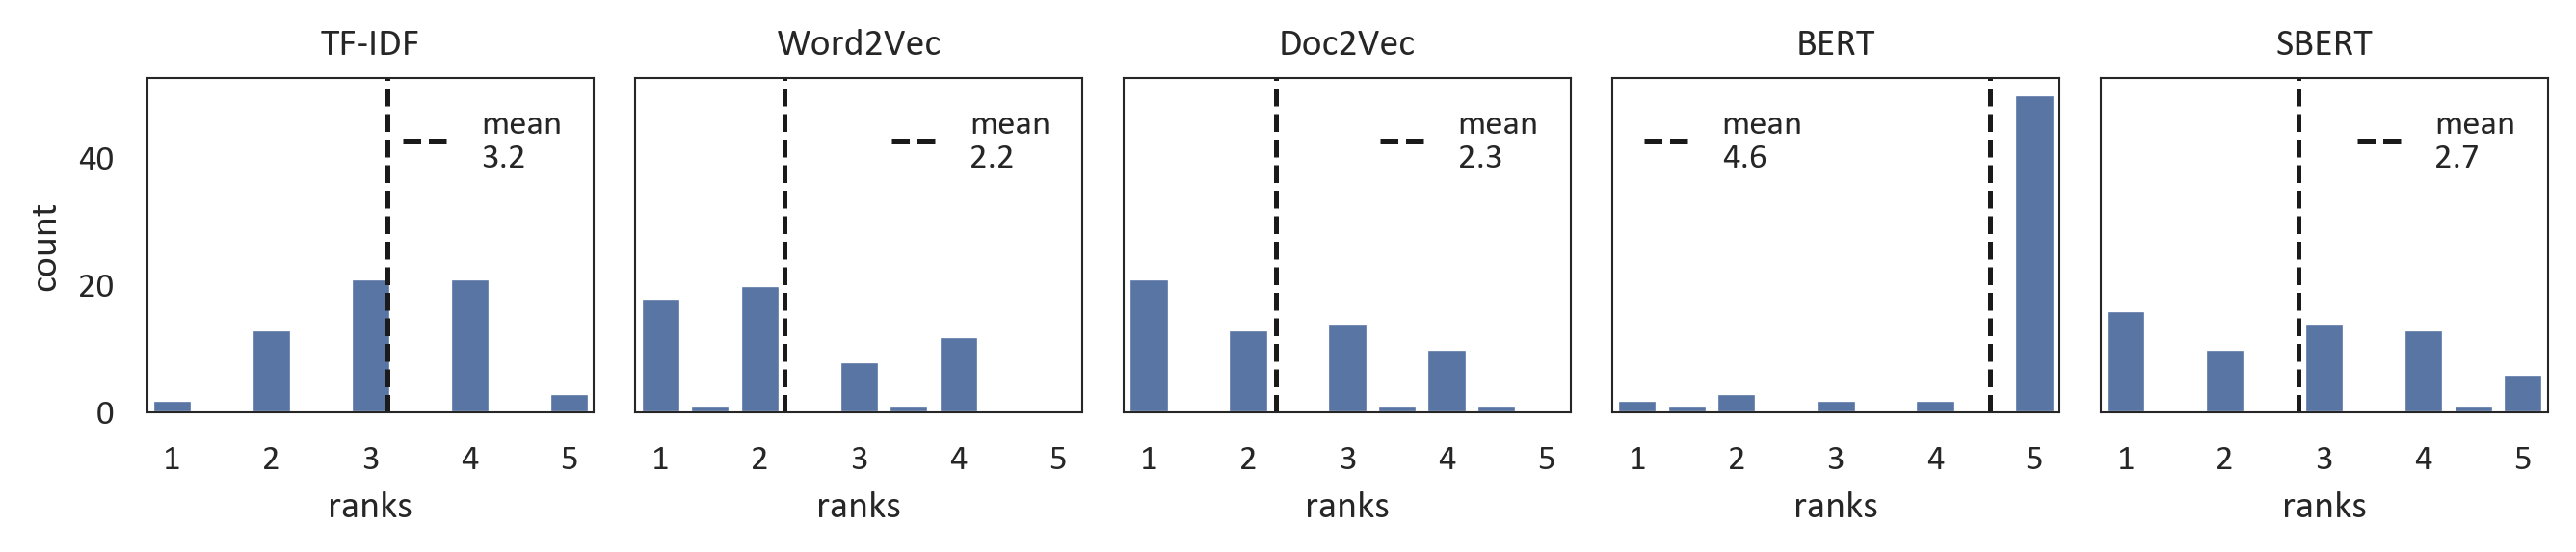

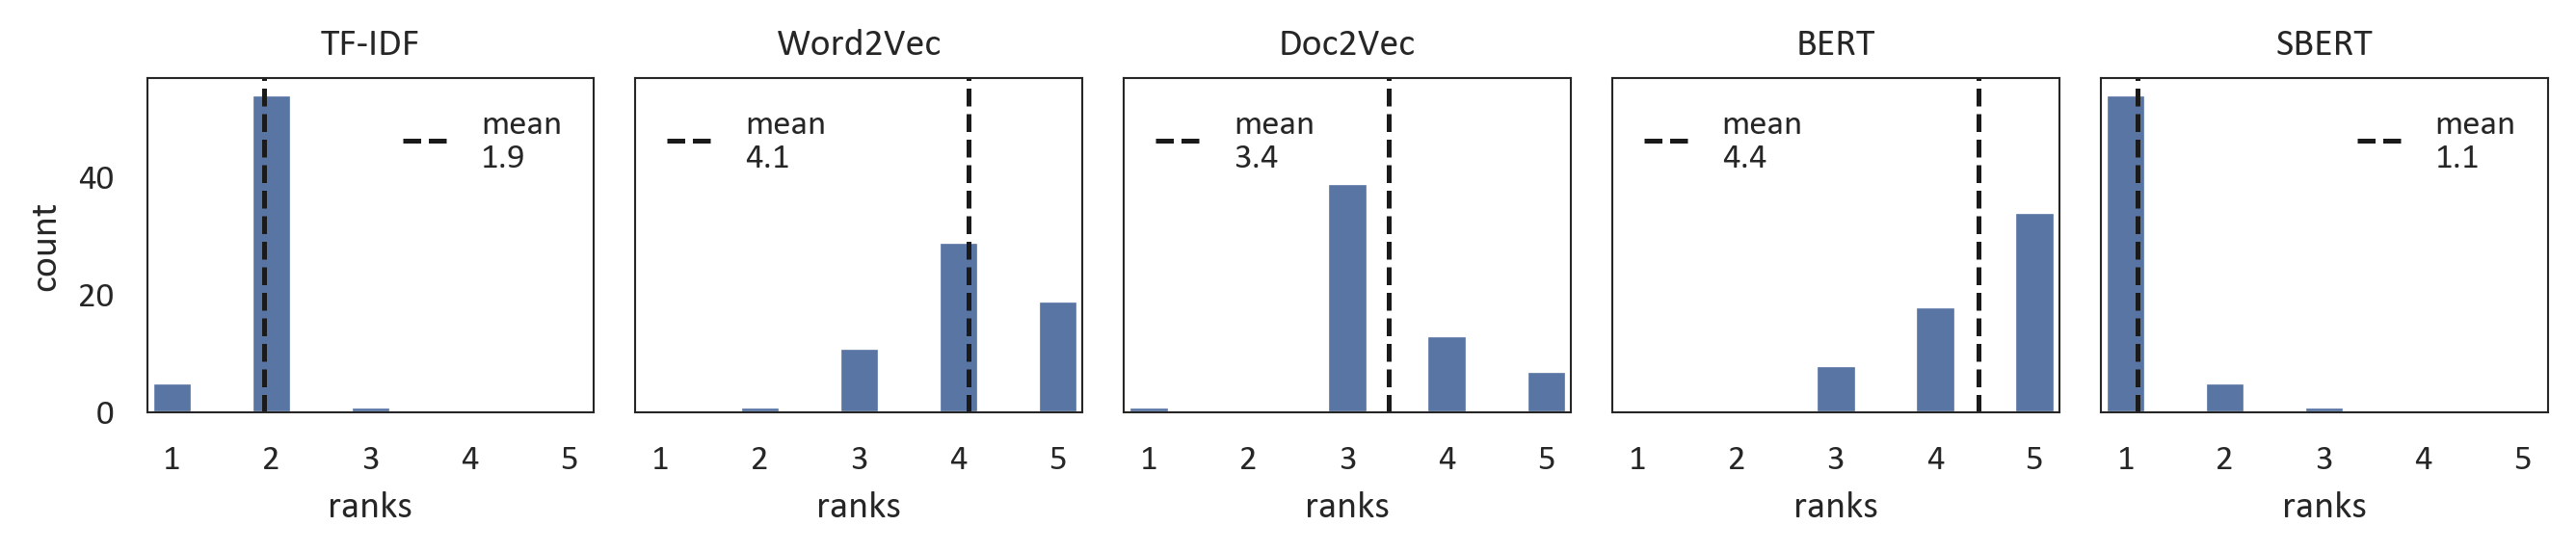

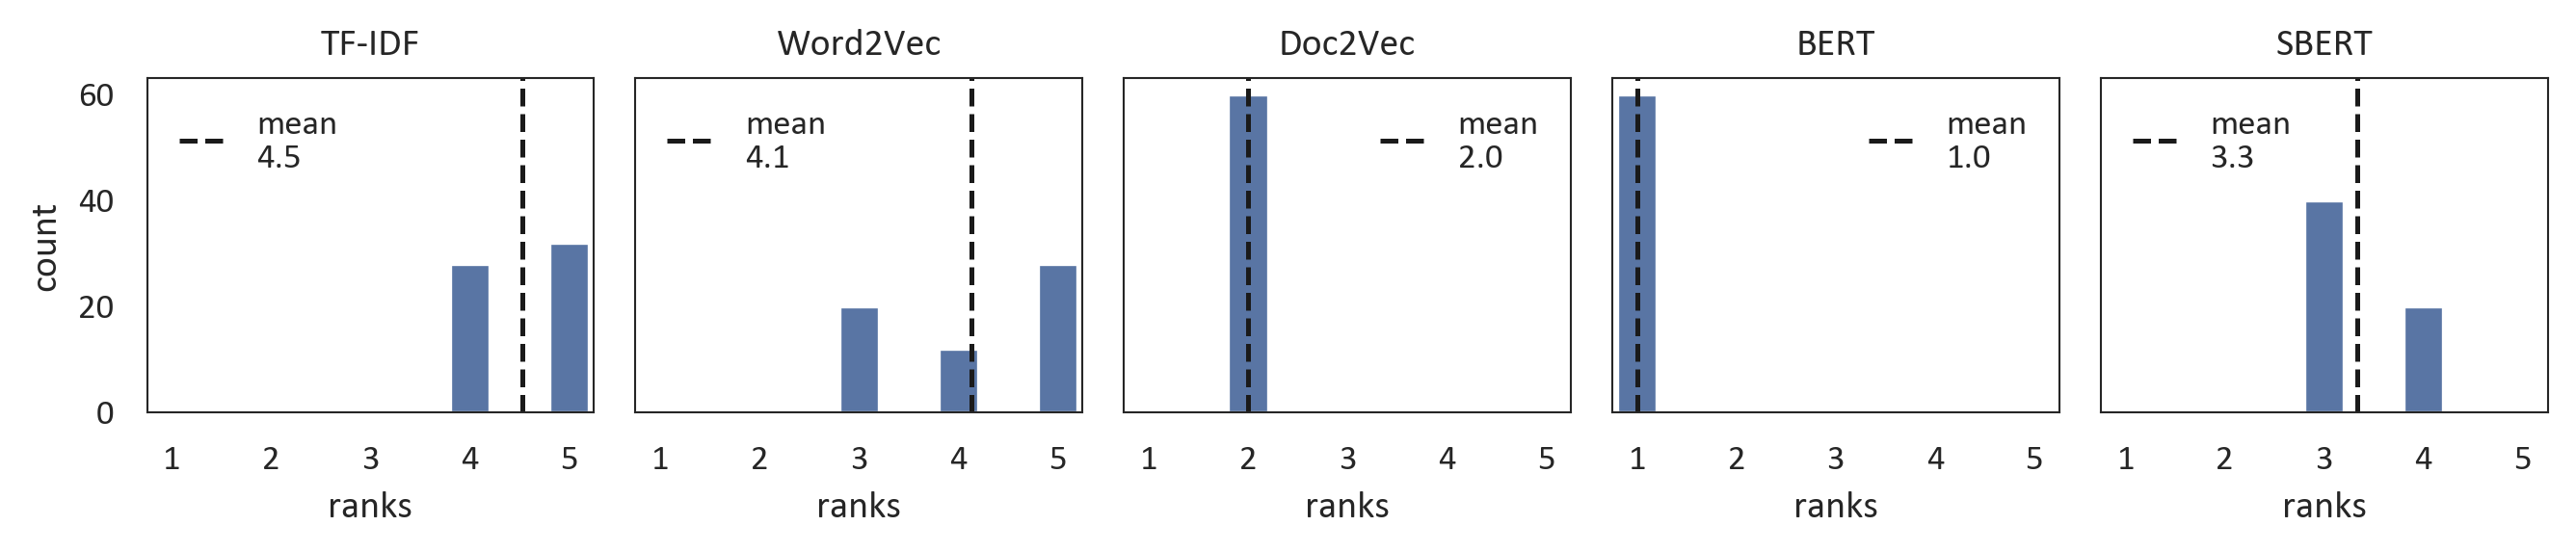

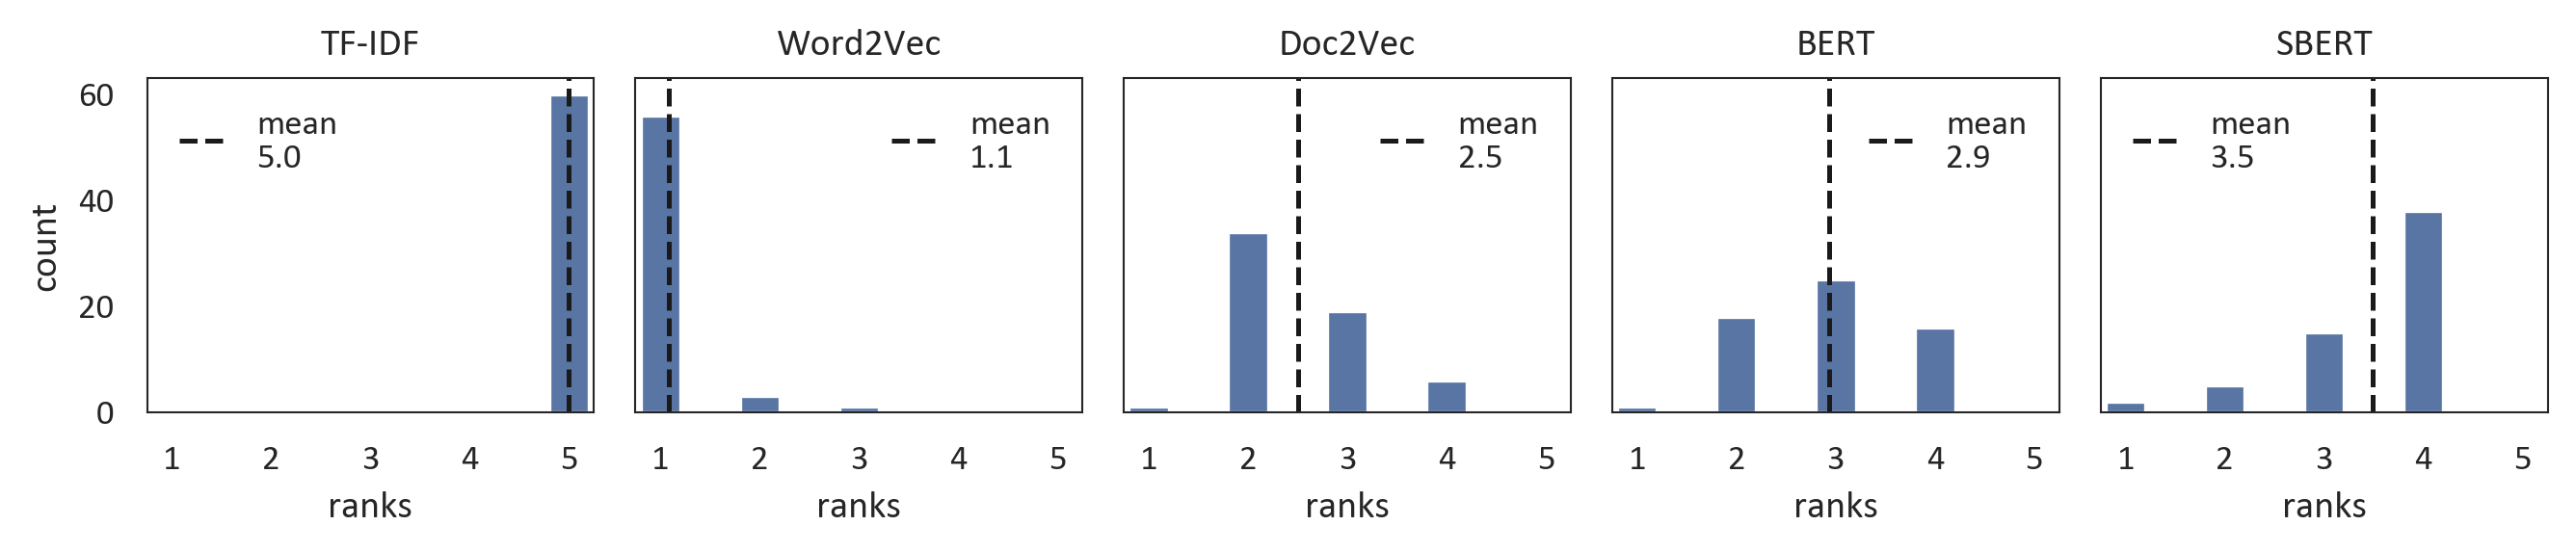

In [67]:

for mi, m in enumerate(metrics):
    fig, axes = plt.subplots(1,5, figsize=(9,2),
                       layout='tight',
                       sharex=True, 
                        sharey=True
                      )

    for vi, v in enumerate(vectzr):
        ax = axes[vi]
        sns.countplot(all_ranks_base_df[all_ranks_base_df['metric'] == m][[v]], 
              x=v, 
              order=[i for i in np.arange(1,5.5,.5)],
              color='b',
                ax=ax
             )
        

        ax.set_xticklabels([int(i) if i%1==0 else "" for i in np.arange(1,5.5,.5) ])
        ax.set_xlabel("ranks")
        
        ax_avg = np.mean(all_ranks_base_df[all_ranks_base_df['metric'] == m][v])
        ax_med = np.median(all_ranks_base_df[all_ranks_base_df['metric'] == m][v])
        
        ax.axvline(x=((ax_avg-1)/4*8), 
                   linestyle='dashed',
                   color='k',
                   label="mean\n{}".format(np.round(ax_avg,1))
                  )
        
        # ax.axvline(x=((ax_med-1)/4*8), 
        #            linestyle='dashed',
        #            color='k',
        #            label="median: {}".format(int(ax_med))
        #           )
        
        ax.legend(frameon=False, handlelength=1.4)

        ax.set_title(vecmap[v])
        # fig.suptitle(metrics_labels[m], y=.95)
        
        if vi > 0:
            ax.set_ylabel("")
            
        for si in ax.spines:
            ax.spines[si].set_linewidth(.5)
        
    fig.savefig('./SOMBR_Stats/__IMG/RankCounts_{}'.format(m), 
                   bbox_inches='tight')

    plt.show()

In [ ]:
all_means = all_results_df.iloc[:,[0,1,2,3,4,6]].groupby(['metric']).mean()
all_means.rename(index={m: metrics_labels[m] for m in metrics}, inplace=True)


all_means.to_csv('./results_summary/all_value_means.csv')

In [ ]:
all_means